# Features 7 & 8 : Graph Metrics and Player Strategy

In this section we are interested in extracting graph measures from the graph. To characterize users and their paths, we will first look  at some graph measures in the whole Wikipedia graph, then we will extract those measures in players paths and see how they evolve.

The goal is to assess if players go towards hubs during a game and then go to more specific pages, or if they go directly to specific pages.

```{note}
Because the code for this part is quite long, it was put in the file `graph_measures.py`.
It contains the fully documented code for this part.
```

In [1]:
from graph_measures import *
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Data loading

First we load the shortest path matrix, then the links and the list of articles.
We use urllib.parse to unquote the links and article names.
At this stage we can already have a look at the shortest path matrix.

In [3]:
shortest_path_df, links, articles = load_data_graph_metrics()

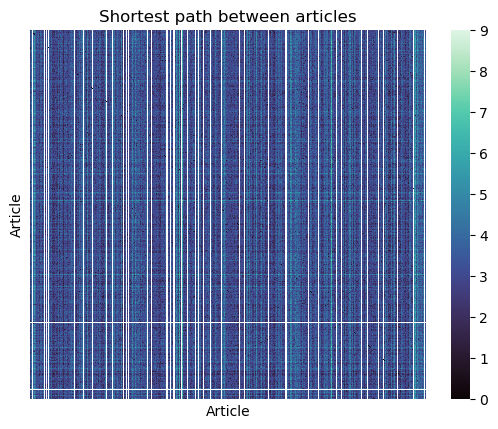

In [4]:
sns.heatmap(shortest_path_df, cmap="mako", xticklabels=False, yticklabels=False)
plt.title("Shortest path between articles")
plt.xlabel("Article")
plt.ylabel("Article")
plt.show()

```{note}
The names are not shown for clarity.
``` 

We see the longest possible path is 9.

## Graph measures
Next, we compute our chosen graph measures.

We will use :
- Degree : the number of articles linked to an article (edges). A hub is expected to have a very high degree.
  An example would be the United States page, which has more than 1800 links.
- Local clustering : how strongly connected the neighbors of an article are. 
  This would be expected to be high in modules, i.e. clusters of related pages that all link to each other.
- Degree centrality : a normalized version of the degree. 
  This is the fraction of nodes a node is connected to, it might be useful as a feature since it's normalized.
- Betweenness centrality : the fraction of shortest paths that pass through a node. 
- Closeness centrality : the average length of the shortest path between a node and all other nodes.
  Both measures of centrality will be useful to define a hub, as hubs should have a higher centrality than other nodes.


We can also compute two global measures : efficiency and modularity.

- Efficiency tells us the fraction of actual connections between nodes and the total possible connections.
- Modularity is a measure of how well the graph is divided into modules, i.e. clusters of nodes that are more connected to each other than to the rest of the graph, for example articles about a specific topic.

---
```{note} 
*About local clustering:*
*While we are mostly interested in hubs in a player's path, we can use clustering to validate some of our rationale about quantifiying players characteristics.*\
*Namely, we do not expect it to significantly inform us about how a player reaches a hub or not, unlike the others; this could have been achieved with another measure of modularity.*
```

In [5]:
links_w_graph_metrics = compute_graph_metrics(links)
display(links_w_graph_metrics.head())

DiGraph with 4592 nodes and 119882 edges
Efficiency (pre-calculated as it takes long to compute) : 0.55814
Modularity: 5.625879039144116e-05


,from,to,degree,clustering,closeness,betweenness,degree_centrality
0,Áedán_mac_Gabráin,Bede,11,0.436364,0.0,0.0,0.002396
1,Áedán_mac_Gabráin,Columba,11,0.436364,0.0,0.0,0.002396
2,Áedán_mac_Gabráin,Dál_Riata,11,0.436364,0.0,0.0,0.002396
3,Áedán_mac_Gabráin,Great_Britain,11,0.436364,0.0,0.0,0.002396
4,Áedán_mac_Gabráin,Ireland,11,0.436364,0.0,0.0,0.002396


We see that the efficiency is slightly above 0.5, which means that more than half of the possible connections are present.
Modularity is $5 \cdot 10^{-5}$, which is very low, meaning that the graph is not well divided into modules. 

We can relate this to the distribution of the degree later, as this might indicate a scale-free graph, i.e. one where the degree distribution follows a power law.

We will now plot the distribution of the measures in the whole graph.

### Plot of graph measures for Wikipedia (subset)

c:\Users\Cyril\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


<Figure size 2000x2000 with 0 Axes>

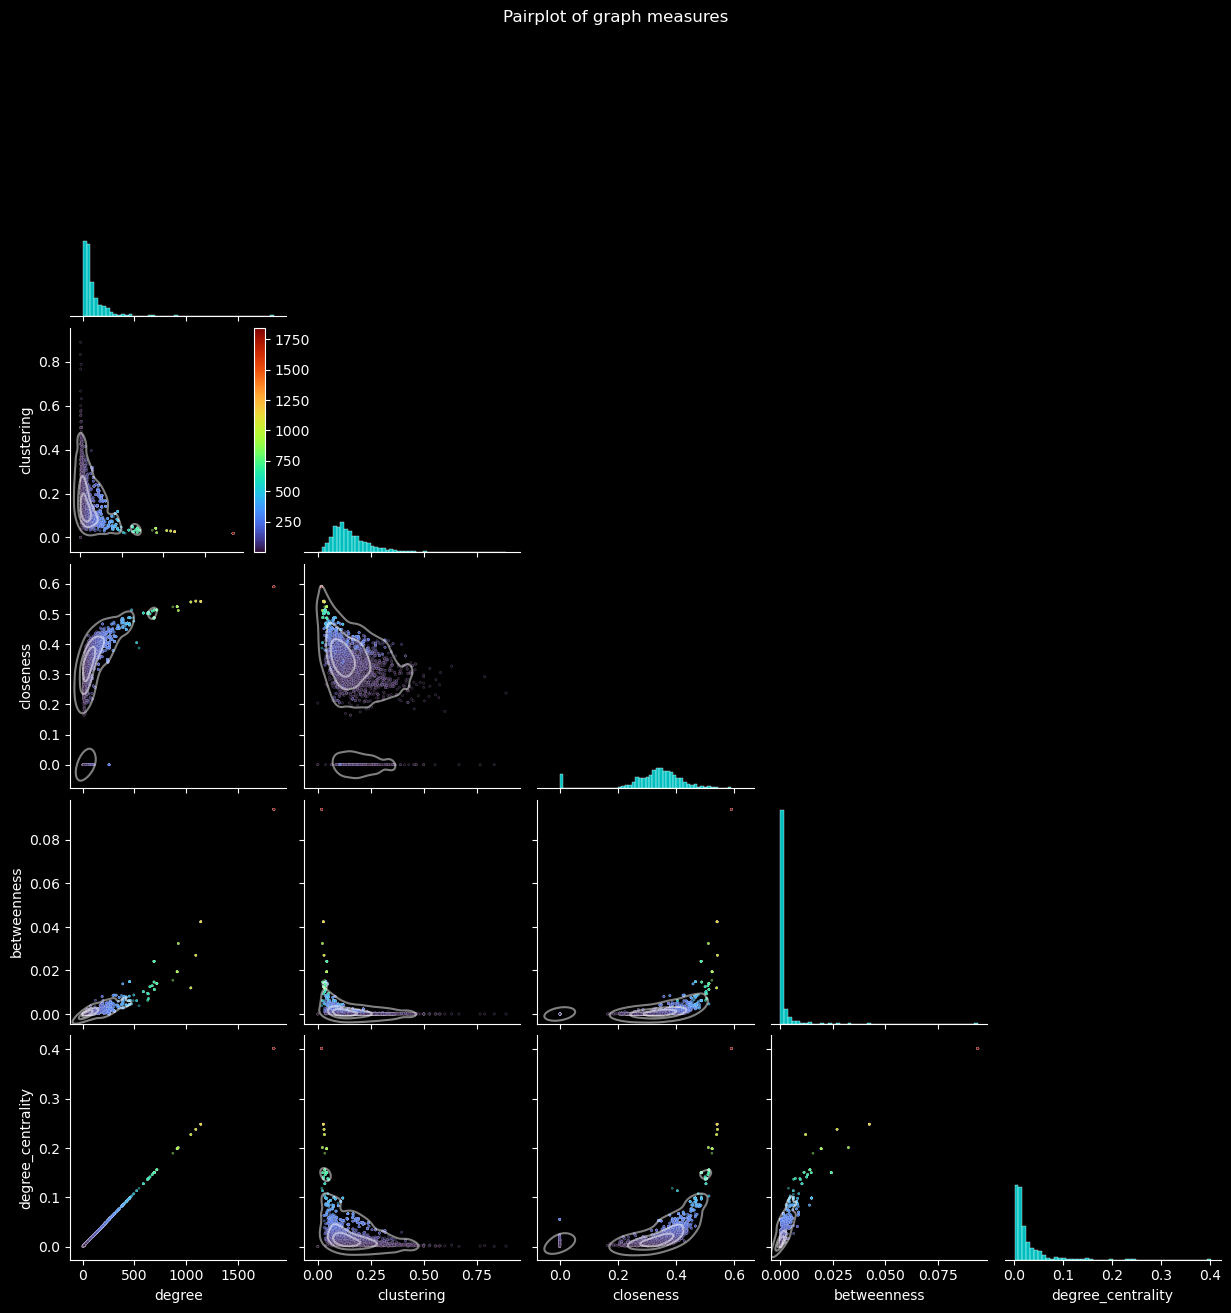

In [6]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(10, 10), dpi=200)

    # sample the data to avoid plotting too many points
    links_plots = links_w_graph_metrics.copy().sample(4000)

    g = sns.pairplot(
        links_plots[
            ["degree", "clustering", "closeness", "betweenness", "degree_centrality"]
        ],
        #  kind="kde",
        diag_kind="hist",
        corner=True,
        plot_kws={"s": 3, "c": links_plots["degree"], "alpha": 0.5, "cmap": "turbo"},
        diag_kws={"bins": 50, "color": "cyan"},
    )
    g.map_lower(sns.kdeplot, levels=4, color="white", alpha=0.5)
    g.tight_layout()
    g.fig.suptitle("Pairplot of graph measures", y=1.05)
    #### colorbar
    sm = plt.cm.ScalarMappable(
        cmap="turbo",
        norm=plt.Normalize(
            vmin=links_plots["degree"].min(), vmax=links_plots["degree"].max()
        ),
    )
    sm.set_array([])
    ax = g.fig.axes[1]
    ax.figure.colorbar(sm, ax=ax)
    ####
    plt.show()

```{note} 
*We use a dark background here to see the colors of the scatter plots better.*\
*The color of the points indicates the degree : red is higher, blue is lower.*\
*The colorbar is only shown once for clarity, but is the same for all subplots.*
```

* We see that betweeness and degree have a very heavy-tailed distribution, with a few nodes having a very high value, and most nodes having a low value, which again is consistent with a scale-free graph. We could check the ccdf to confirm this.
* Aside from closeness-clustering, other measures seem to have an exponential relationship.

* Degree and degree centrality are obviously perfectly correlated.

## Measures per path

We will now load the user paths to apply the same measures to them.

In [7]:
paths_finished, paths_unfinished = load_and_prepare_paths_dfs_for_metrics()

In [8]:
display(paths_finished.head())

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0


In [9]:
display(paths_unfinished.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout


Because our analysis relies on measures in a path with several articles, we will discard all unfinished paths with less than two articles.

In [10]:
paths_unfinished_filter = paths_unfinished.copy()
paths_unfinished_filter = paths_unfinished_filter[
    paths_unfinished_filter["path"].apply(len) > 2
]
display(paths_unfinished_filter.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout
5,131600803df4895e,2011-02-07 17:42:37,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout
6,486bb79910fe9dd2,2011-02-07 18:01:00,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout
7,6d136e371e42474f,2011-02-07 18:07:50,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart
9,6d136e371e42474f,2011-02-07 18:41:50,2006,"[Logic, Computer_science, Science, Physical_sc...",Moon_landing,timeout


### Finished paths
Here we check the distribution of those measures before and after the maximum of the path degree in finished paths.

#### Graph measures distribution

In [11]:
path_metrics = compute_path_metrics(links=links_w_graph_metrics, paths=paths_finished)
path_metrics_around_max = get_metrics_around_max(path_metrics)

Attemping to load metrics from C:\Users\Cyril\Desktop\Code\ada-2023-project-adamants\data\path_metrics.pkl
Loaded metrics successfully from C:\Users\Cyril\Desktop\Code\ada-2023-project-adamants\data\path_metrics.pkl


One way to see if players go towards hubs is to look at the evolution of the measures along the path before and after they reach their paths's maximal degree.
We will plot the measures before and after the degree peak, and see if there is a difference.

We also introduce a new measure : degree evolution, which is the derivative of the degree along the path. Since this is a discrete derivative, we simply subtract the degree of the previous article from the current one.

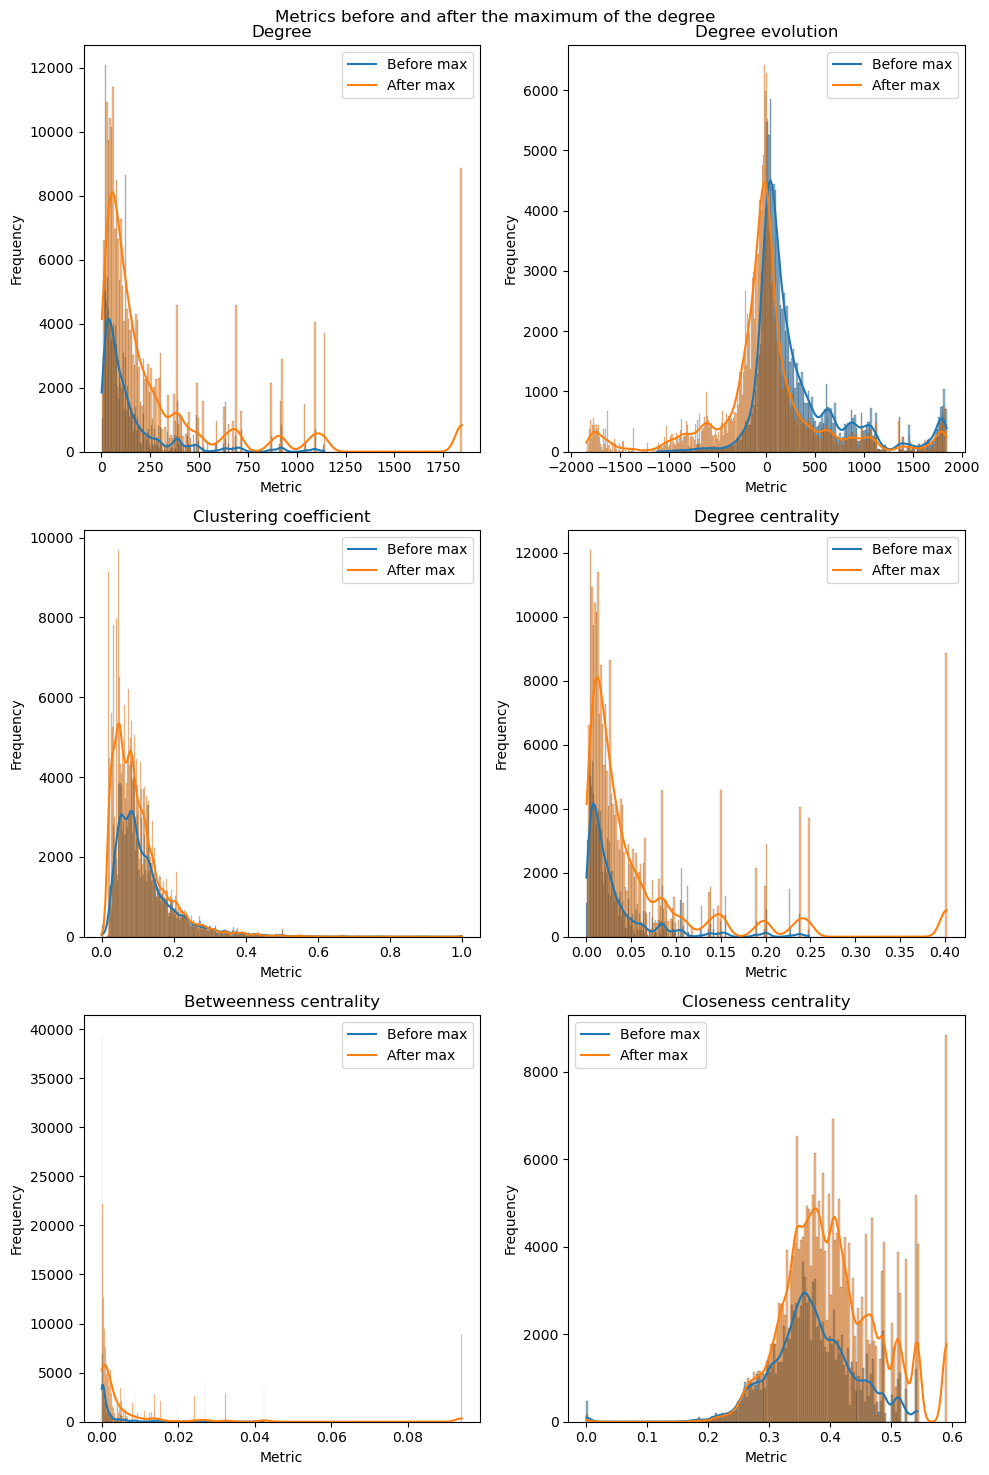

In [12]:
plot_histograms_of_metrics_before_and_after(path_metrics_around_max)

#### Using slopes to assess player strategy

**From the previous plot, it is difficult to extract any differences but for the count.** We only clearly see that there are more nodes after the maximal degree and not before, which could make sense if players actively seek hubs and only then go towards the goal, but this is not so useful.

We also see in Degree evolution that the derivative has more positive values before the maximum degree, whereas after the max it has more negative values; this is more representative of a player's strategy.

Let's see if we can extract these trends more clearly by looking at a linear fit before and after the maximum degree 

```{important}
In the following, **the maximum itself is not included** in the linear fit, so that we do not always have a positive then negative slope
```

To clarify, we use the following functions for each metric :

In [13]:
def compute_slope(path_metric_evolution):
    """Quantifies if the slope of a metric in a path is increasing or decreasing.

    This is done by fitting a line to the metric and returning the slope.
    """
    idx = np.isfinite(path_metric_evolution)
    if len(path_metric_evolution[idx]) < 2:  # we need at least 2 points to fit a line
        return np.nan
    fitted_line = np.polyfit(
        np.arange(len(path_metric_evolution))[idx], path_metric_evolution[idx], 1
    )
    return fitted_line[0]


def estimate_strategy(metric_array, metric=compute_slope):
    """Uses the maximum of the degree in the path to estimate the strategy of the user.

    The goal is to see if the degree tends to increase before reaching the maximum and then decrease.

    Args:
        metric_array (np.array): array of the metric for the pages in the path
        metric (function): function to use to compute the metric of the degree evolution before and after the maximum. Can use compute_slope or np.mean for example.

    Returns:
        m_before (float): the metric of the degree evolution before the maximum
        m_after (float): the metric of the degree evolution after the maximum
    """
    if np.isnan(metric_array).all():
        return np.nan
    max_id = np.nanargmax(metric_array)
    if max_id == 0:
        return np.nan
    elif max_id == len(metric_array) - 1:
        return np.nan
    else:
        m_before = metric(metric_array[:max_id])
        m_after = metric(metric_array[max_id - 1 :])  # SKIP maximum
        if m_before is np.nan or m_after is np.nan:
            return np.nan
        return m_before, m_after

Here we compute and plot the linear fits for all the measures.

In [14]:
path_metrics["path_degree_evolution"] = path_metrics["path_degree"].map(
    compute_path_degree_evolution
)
metrics_slopes = compute_metric_slopes(path_metrics)

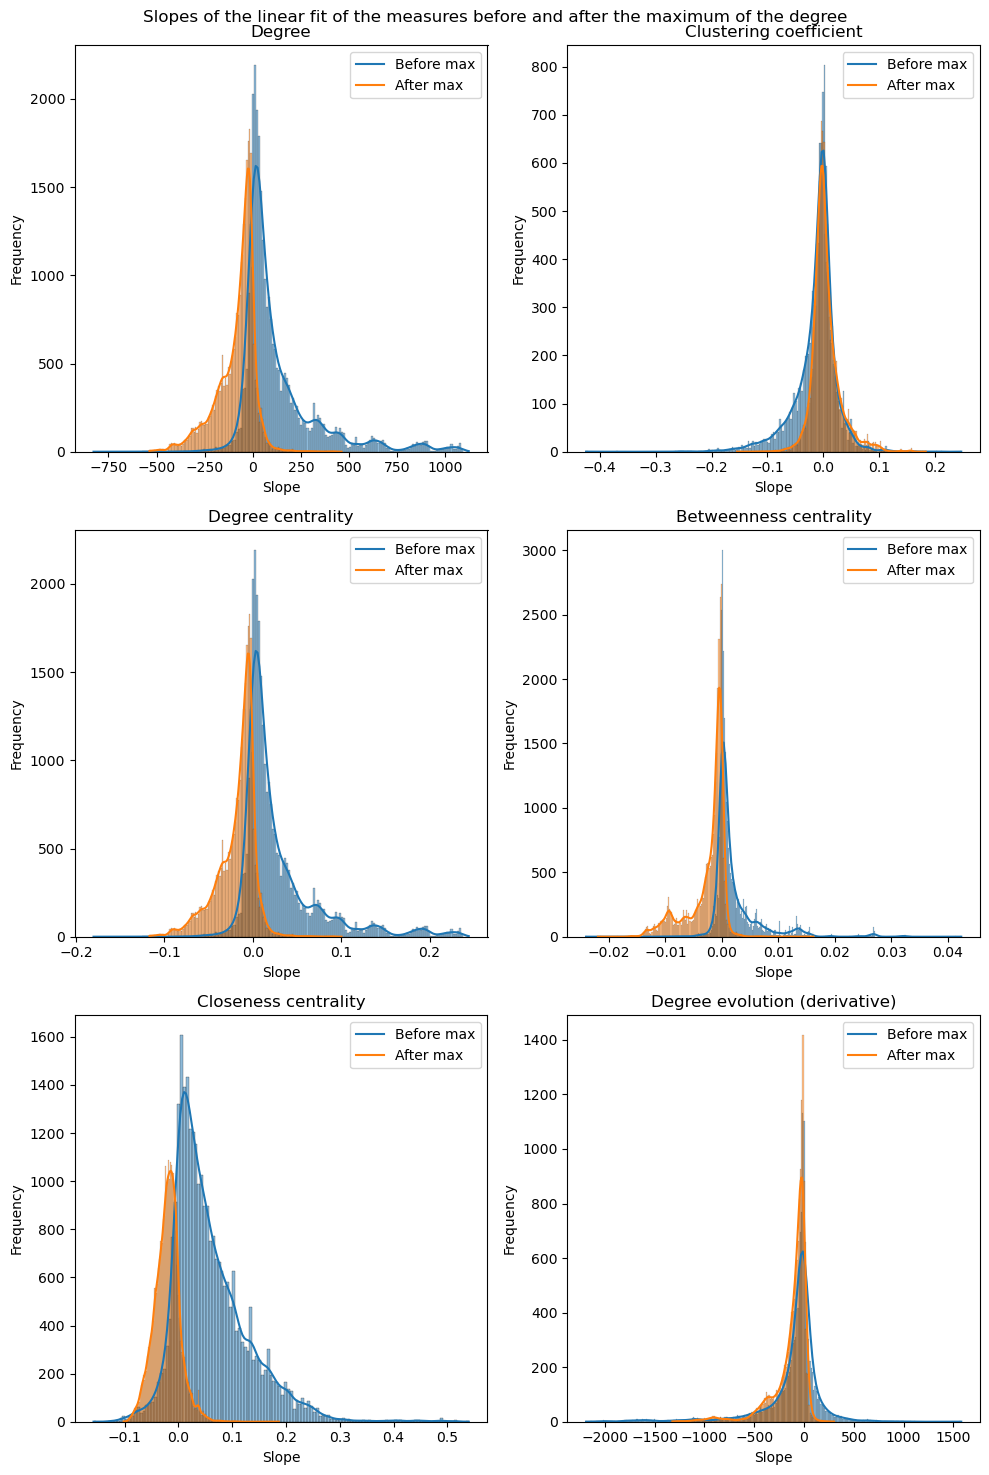

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle(
    "Slopes of the linear fit of the measures before and after the maximum of the degree"
)

for ax in axs.flatten():
    ax.set_xlabel("Slope")
    ax.set_ylabel("Frequency")

metric_titles = [
    "Degree",
    "Clustering coefficient",
    "Degree centrality",
    "Betweenness centrality",
    "Closeness centrality",
    "Degree evolution (derivative)",
]

for i, metric in enumerate(metrics_slopes):
    cur_ax = axs.flatten()[i]
    sns.histplot(data=metric, x=f"{metric.columns[0]}", ax=cur_ax, kde=True)
    sns.histplot(data=metric, x=f"{metric.columns[1]}", ax=cur_ax, kde=True)
    cur_ax.set_title(metric_titles[i])
    cur_ax.legend(["Before max", "After max"])

fig.tight_layout()
plt.show()

We see that not only are the distributions of the slope before and after fairly different, but also that the sign of the slopes tends to be more positive before and more negative after.

Only clustering coefficient and degree evolution do not show this trend, which makes sense since they are not too directly related with the "hub-likeness" of a node.

However, because of how we obtain the slopes, it could be that we have a bias towards always having a positive slope before and a negative slope after, even though we omit the maximum degree itself from the linear fit.

**Despite this, these plots are meaningful because we can see how *strongly* negative or positive a path's slope is, and we can expect that a "good" player will have, for example for degree, a more positive slope before and a more negative slope after, because they are good at quickly reaching hubs and then going to more specific pages.**

The same applies for centrality (both betweenness and closeness).

Again, degree centrality is the same as degree, but the normalization could help when comparing players.

### Unfinished paths

We can now repeat the same analysis for unfinished paths.

#### Graph measures distribution

Attemping to load metrics from C:\Users\Cyril\Desktop\Code\ada-2023-project-adamants\data\unfinished_path_metrics.pkl
Loaded metrics successfully from C:\Users\Cyril\Desktop\Code\ada-2023-project-adamants\data\unfinished_path_metrics.pkl


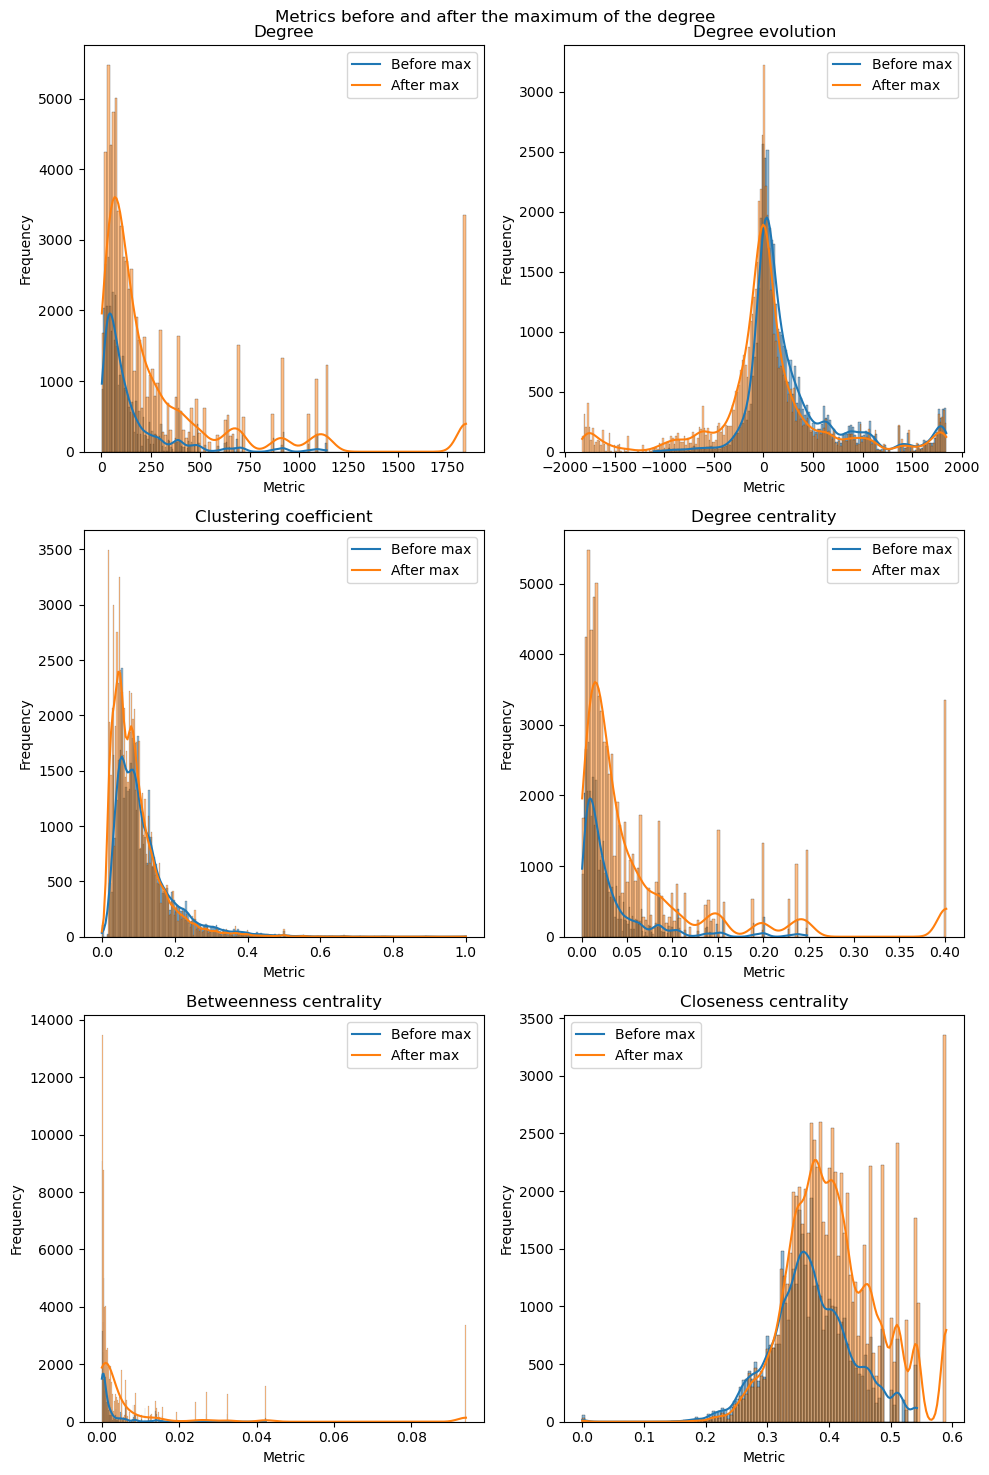

In [16]:
unfinished_path_metrics = compute_path_metrics(
    links=links_w_graph_metrics,
    paths=paths_unfinished_filter,
    pickle_path="../data/unfinished_path_metrics.pkl",
)
unfinished_path_metrics_around_max = get_metrics_around_max(unfinished_path_metrics)
plot_histograms_of_metrics_before_and_after(unfinished_path_metrics_around_max)

#### Unfinished paths slopes

In [17]:
unfinished_path_metrics["path_degree_evolution"] = unfinished_path_metrics[
    "path_degree"
].map(compute_path_degree_evolution)
unfinished_metrics_slopes = compute_metric_slopes(unfinished_path_metrics)

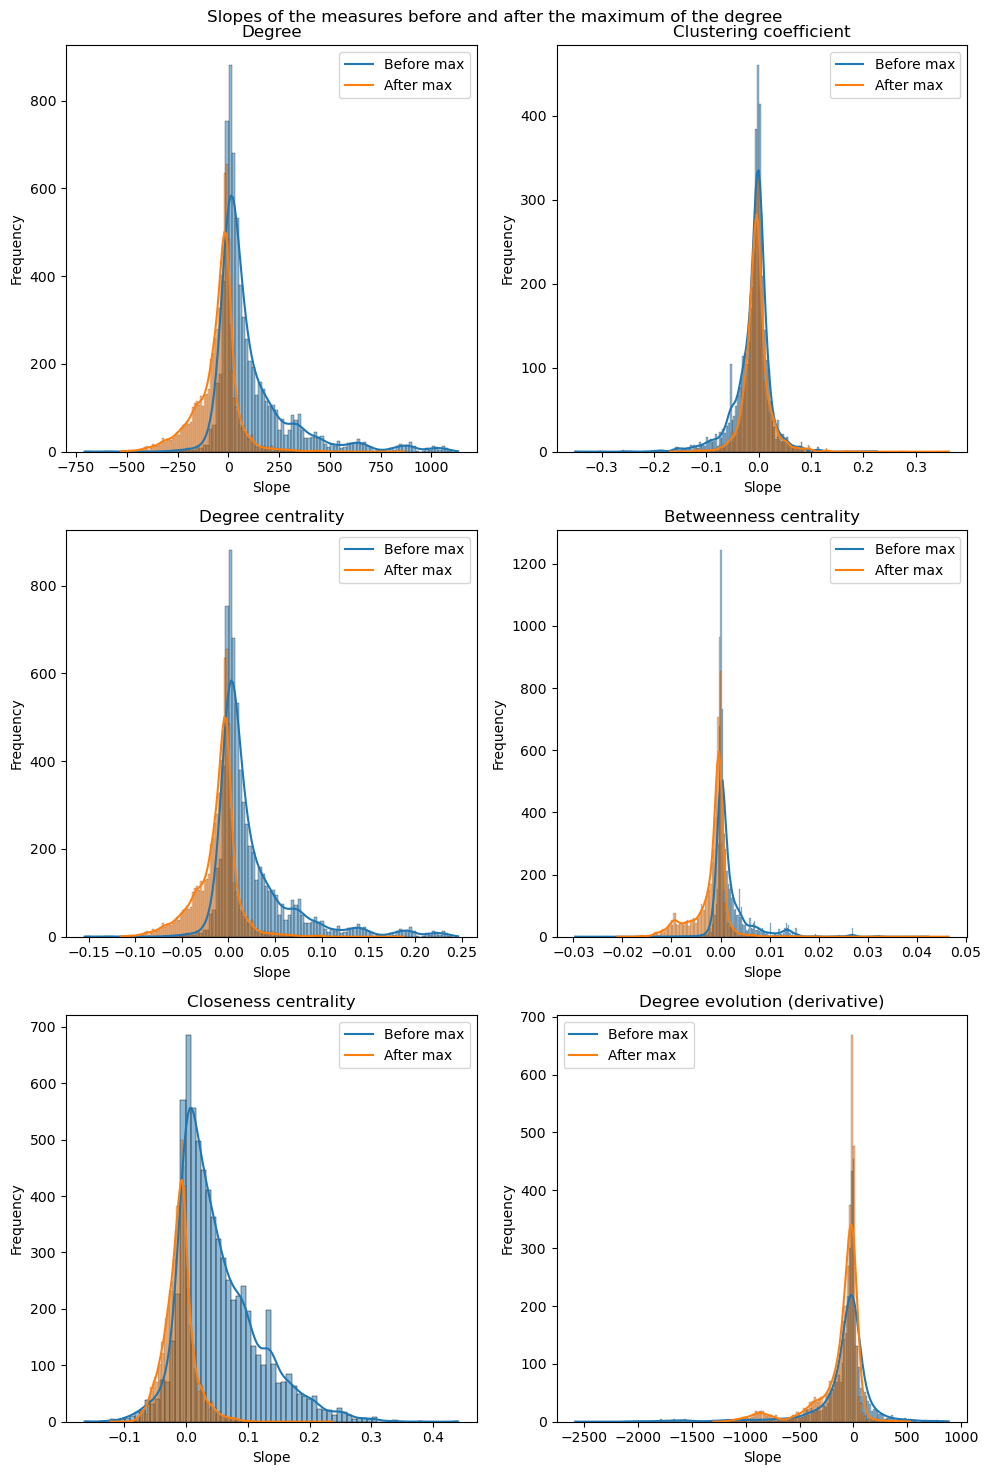

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle("Slopes of the measures before and after the maximum of the degree")

for ax in axs.flatten():
    ax.set_xlabel("Slope")
    ax.set_ylabel("Frequency")

unfinished_metric_titles = [
    "Degree",
    "Clustering coefficient",
    "Degree centrality",
    "Betweenness centrality",
    "Closeness centrality",
    "Degree evolution (derivative)",
]

for i, metric in enumerate(unfinished_metrics_slopes):
    cur_ax = axs.flatten()[i]
    sns.histplot(data=metric, x=f"{metric.columns[0]}", ax=cur_ax, kde=True)
    sns.histplot(data=metric, x=f"{metric.columns[1]}", ax=cur_ax, kde=True)
    cur_ax.set_title(unfinished_metric_titles[i])
    cur_ax.legend(["Before max", "After max"])

fig.tight_layout()
plt.show()